In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization, StatsBase, Statistics

In [2]:
using ProgressMeter


In [3]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

In [4]:
function winning(opp_move)
    best_moves = Dict(1 => 2, 2 => 3, 3 => 1)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

In [5]:
@model function agent(opponent_chn, opponent_history, opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(opp_prior_policy) #prior
    if depth == -1 # the simplest agent
        opponent_history = []
    end
    if depth <= 0
        for i in 1:length(opponent_history)
            opponent_history[i] ~ Categorical(beta_opp) # observe
        end
        next_opp_move ~ Categorical(beta_opp) # sample
    end
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:my_move][idx, 1]
        
        # init alternative way to Dirac distribution
        complete_p_dirac = (1 - PDIRAC) / 2
        phi = fill(complete_p_dirac, 3)
        phi[convert(Int, opp_move_sample)] = PDIRAC
        
        next_opp_move ~ Categorical(phi) # observe
    end
    winning_move = winning(next_opp_move)
    
    # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[convert(Int,winning_move)] = PDIRAC
    
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

In [6]:
# Plot the results
function plotChn(chn)
    histogram(chn[:my_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

In [7]:
function run_two_agents_theory_of_mind(my_model, other_model, opponent_prior, my_prior , opponent_history, my_history, depth, show_progress = true)
    second_chn_i = []
    first_chn_i = []
    p = Progress(depth)
    if depth == -1
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, -1),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, -1), INFALG, N , progress = false) 
    end 
    for i in 0:depth
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, i),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, i), INFALG, N , progress = false)
        if show_progress
            ProgressMeter.next!(p)
        end
    end
    return second_chn_i
end

run_two_agents_theory_of_mind (generic function with 2 methods)

## Depth 0

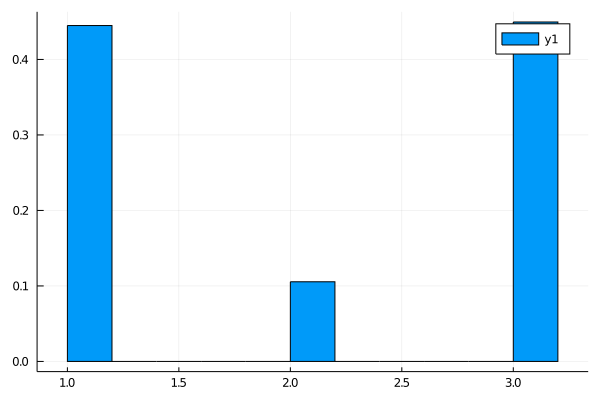

In [8]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,9,2], [], [], -1))

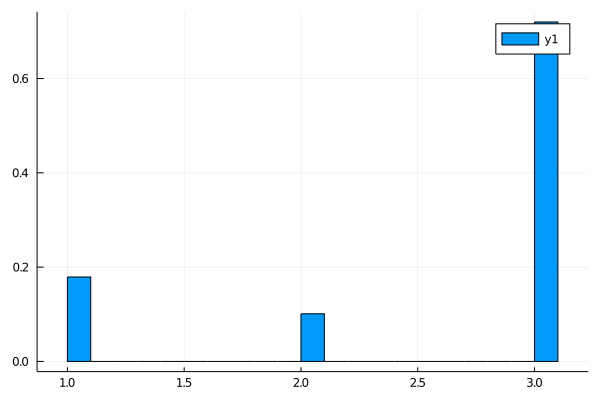

In [9]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,9,2] , [1,9,2], [], [], -1))

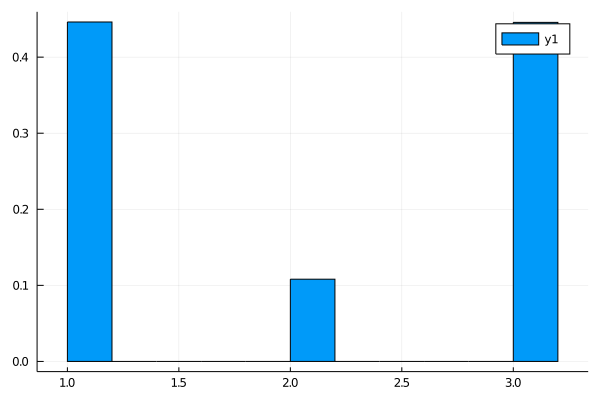

In [10]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

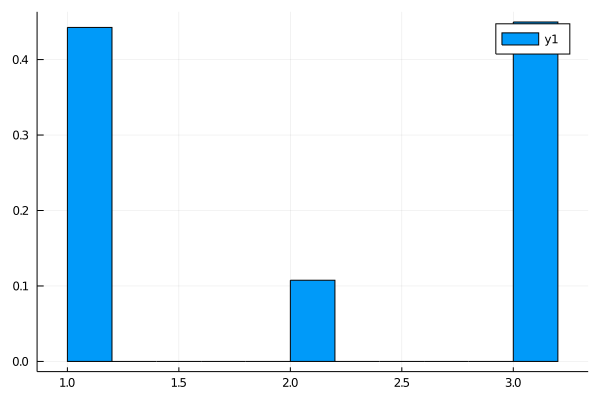

In [11]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

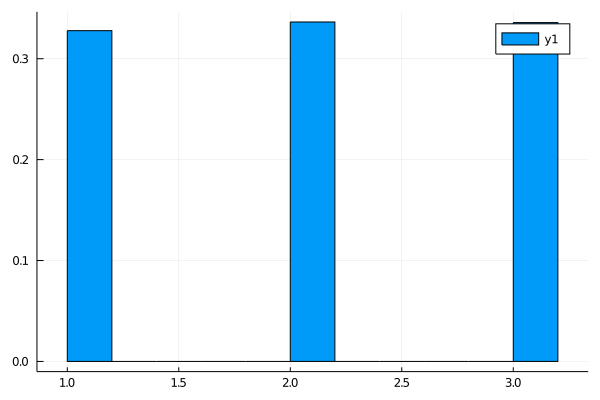

In [12]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 0))

## Depth 3

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


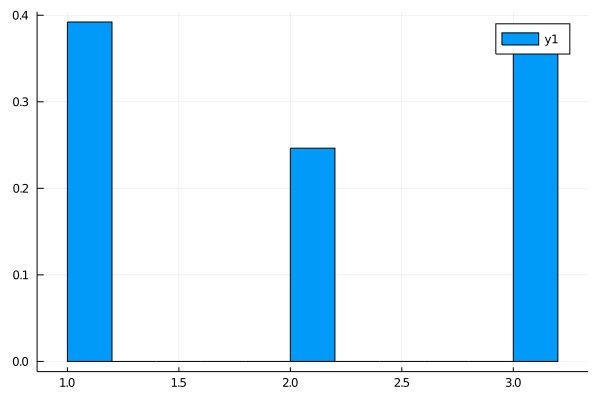

In [13]:
plotChn(run_two_agents_theory_of_mind(agent, agent,[1,5,5], [1,1,1], [], [], 3))

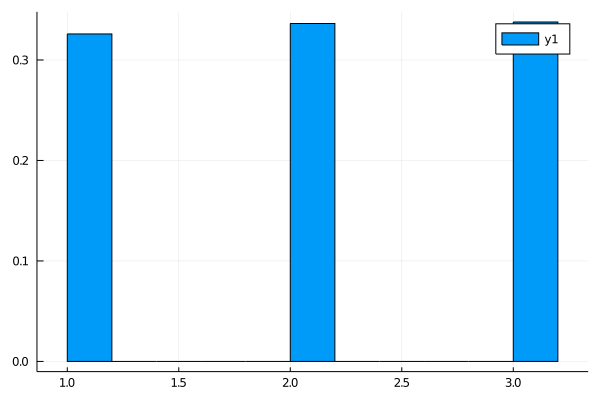

In [14]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 3,false))

## Depth 10

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


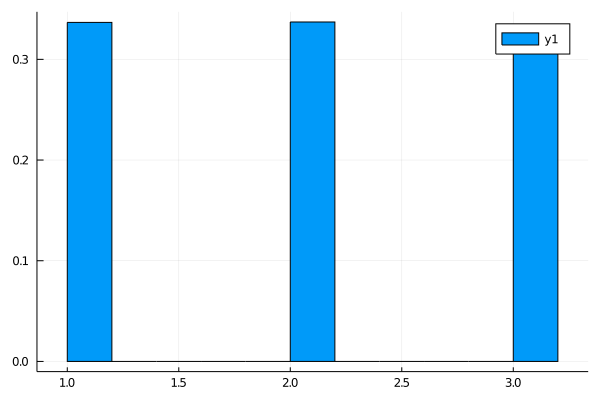

In [15]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5], [1,1,1], [], [], 10))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


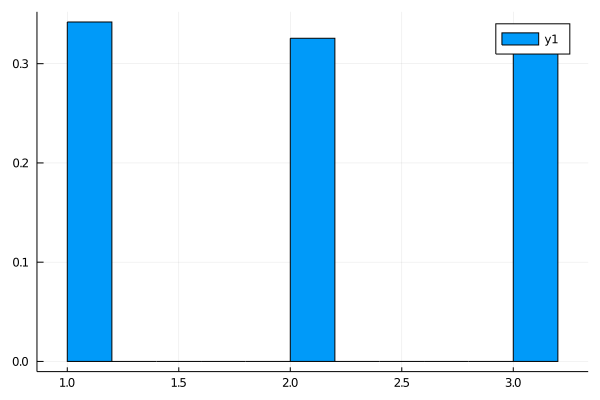

In [16]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 10))

## Depth 20

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


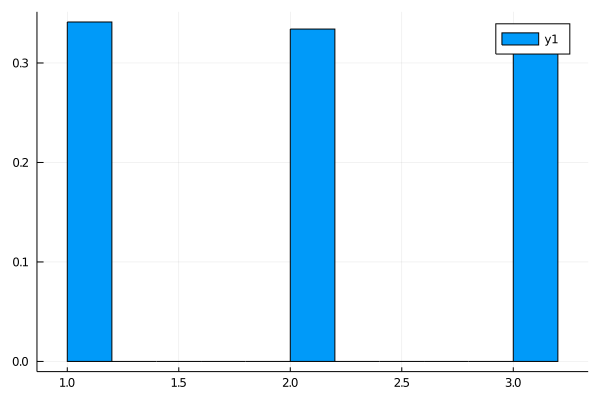

In [17]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 20))

Progress: 100%|█████████████████████████████████████████| Time: 0:02:51


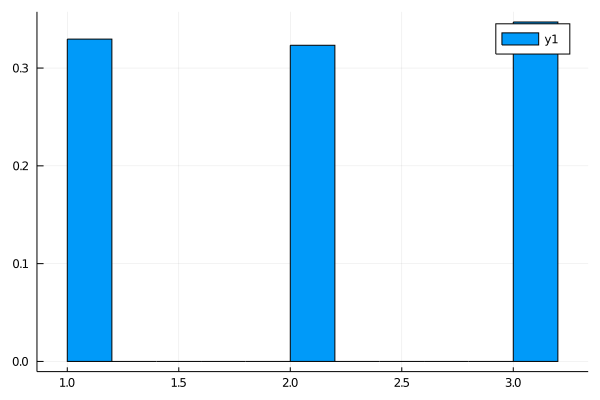

In [18]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 20))

# Simulations

In [8]:
function sample_move(chn)
    weights = exp.(chn[:lp][:, 1])
    weights = Weights(weights/sum(weights))
    idx = sample(collect(1:length(weights)), weights)
    move_sample = chn[:my_move][idx, 1]
    return move_sample
end

sample_move (generic function with 1 method)

In [9]:
function move(agent, other_agent, other_agent_history, my_history, other_player_prior, my_depth=1)
    other_agent_history = length(other_agent_history) > 0 ? other_agent_history : [1]
    other_agent_history = Array{Int}(other_agent_history)
    my_history = length(my_history) > 0 ? my_history : [1]
    my_history = Array{Int}(my_history)
    m = agent(other_agent, other_agent_history, other_player_prior, my_depth)
    chain = run_two_agents_theory_of_mind(agent, other_agent, other_player_prior, [1,1,1] , other_agent_history, my_history, my_depth, false)
    return sample_move(chain)
end

move (generic function with 2 methods)

In [10]:
function game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1])
    first_player = agent
    second_player = agent
    num_of_rounds = 50
    first_player_history = []
    second_player_history = []
    
    @showprogress for i in 1:num_of_rounds
        m1 = move(first_player, second_player, second_player_history, first_player_history, second_player_prior_policy, first_player_depth)
        push!(first_player_history, m1)
        m2 = move(second_player, first_player, first_player_history, second_player_history, first_player_prior_policy, second_player_depth)
        push!(second_player_history, m2)
    end
    return first_player_history, second_player_history
 end

game (generic function with 5 methods)

In [11]:
function score(history)
    first_player_history, second_player_history = history
    first_wins = 0
    ties = 0
    second_wins = 0
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
    end
    return [first_wins, ties, second_wins]
end

score (generic function with 1 method)

In [12]:
function accumulated_score(history)
    first_player_history, second_player_history = history
    first_wins, ties, second_wins = 0, 0, 0
    acc_result = []
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
        push!(acc_result, [first_wins, ties, second_wins])
    end
    return acc_result
end

accumulated_score (generic function with 1 method)

In [14]:
function plot_accumulated_score(acc_result)
    n = length(acc_result)
    acc_result = transpose(reduce(hcat, acc_result))
    plot(1:n, acc_result, alpha = 0.3)
end

plot_accumulated_score (generic function with 1 method)

In [15]:
function display_score(score)
    num_of_wins_first, num_of_ties, num_of_wins_second = score
    println("first player won: $num_of_wins_first")
    println("second player won: $num_of_wins_second") 
    println("ties: $num_of_ties") 
end

display_score (generic function with 1 method)

In [16]:
NUM_OF_EXPIREMENTS = 15

15

In [17]:
function mean_and_var(results)
    results = reduce(hcat, results)
    mean_results = mean(results,dims=2)
    var_results = std(results,dims=2)
    return mean_results , var_results
end

mean_and_var (generic function with 1 method)

In [18]:
function simulate_game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = 10)
    plt = plot()
    scores = []
    for i in 1:num_of_expirements
        game_result = game(first_player_depth,second_player_depth, first_player_prior_policy, second_player_prior_policy)
        acc_result = accumulated_score(game_result)
        score_result = score(game_result)
        push!(scores,score_result)
        n = length(acc_result)
        acc_result = transpose(reduce(hcat, acc_result))
        plot!(acc_result, alpha = 0.3, legend = false, label = ["p1 wins" "ties" "p2 wins"] , color = [1 2 3])
    end
    display(plt)
    mean_results, var_results = mean_and_var(scores)
    println("first win: $(mean_results[1])+-$(var_results[1])")
    println("ties: $(mean_results[2])+-$(var_results[2])")
    println("second win: $(mean_results[3])+-$(var_results[3])")
end 

simulate_game (generic function with 6 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:33
Progress: 100%|█████████████████████████████████████████| Time: 0:04:53
Progress: 100%|█████████████████████████████████████████| Time: 0:04:28
Progress: 100%|█████████████████████████████████████████| Time: 0:04:00
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:58
Progress: 100%|█████████████████████████████████████████| Time: 0:04:22
Progress: 100%|█████████████████████████████████████████| Time: 0:04:17
Progress: 100%|█████████████████████████████████████████| Time: 0:04:18
Progress: 100%|█████████████████████████████████████████| Time: 0:03:47
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:44
Progress: 100%|█████████████████████████████████████████| Time: 0:05:06
Progress: 100%|█████████████████████████████████████████| Time: 

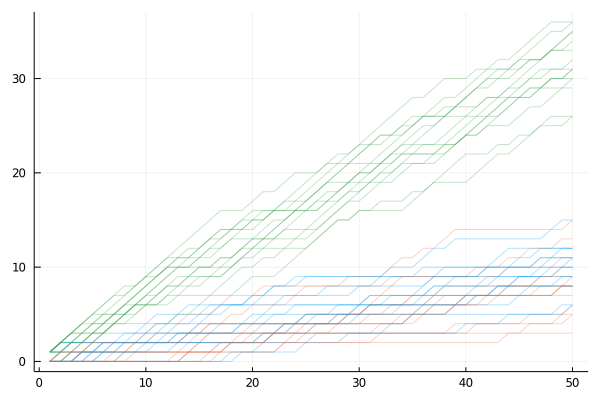

first win: 10.0+-2.4201534780139164
ties: 8.333333333333334+-3.1091263510296048
second win: 31.666666666666668+-3.2219485379118615


In [75]:
simulate_game(-1, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:29
Progress: 100%|█████████████████████████████████████████| Time: 0:04:26
Progress: 100%|█████████████████████████████████████████| Time: 0:04:49
Progress: 100%|█████████████████████████████████████████| Time: 0:04:54
Progress: 100%|█████████████████████████████████████████| Time: 0:04:51
Progress: 100%|█████████████████████████████████████████| Time: 0:04:40
Progress: 100%|█████████████████████████████████████████| Time: 0:04:30
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
Progress: 100%|█████████████████████████████████████████| Time: 0:03:30
Progress: 100%|█████████████████████████████████████████| Time: 0:03:25
Progress: 100%|█████████████████████████████████████████| Time: 

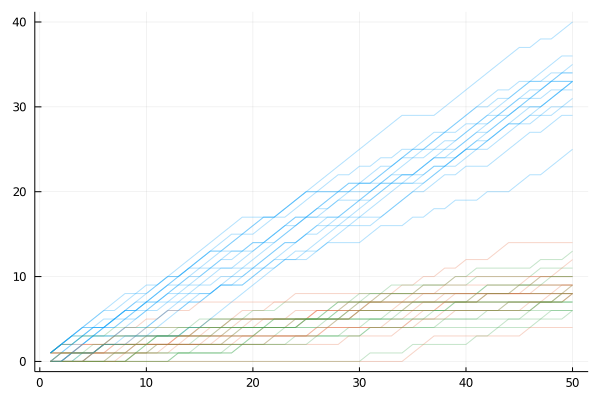

first win: 32.733333333333334+-3.3480626949810555
ties: 8.933333333333334+-2.1865389045137937
second win: 8.333333333333334+-2.0236694629405503


In [76]:
simulate_game(-1, -1, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:30
Progress: 100%|█████████████████████████████████████████| Time: 0:04:45
Progress: 100%|█████████████████████████████████████████| Time: 0:05:46
Progress: 100%|█████████████████████████████████████████| Time: 0:04:31
Progress: 100%|█████████████████████████████████████████| Time: 0:04:28
Progress: 100%|█████████████████████████████████████████| Time: 0:04:33
Progress: 100%|█████████████████████████████████████████| Time: 0:04:41
Progress: 100%|█████████████████████████████████████████| Time: 0:04:08
Progress: 100%|█████████████████████████████████████████| Time: 0:03:25
Progress: 100%|█████████████████████████████████████████| Time: 0:03:26
Progress: 100%|█████████████████████████████████████████| Time: 0:03:46
Progress: 100%|█████████████████████████████████████████| Time: 0:03:38
Progress: 100%|█████████████████████████████████████████| Time: 0:03:25
Progress: 100%|█████████████████████████████████████████| Time: 

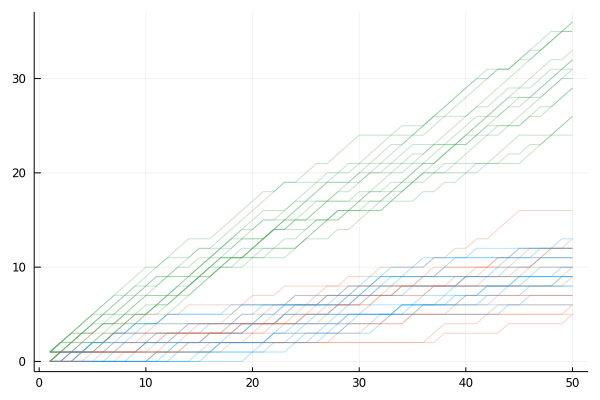

first win: 9.6+-1.9566735620873064
ties: 9.4+-3.3123146848433
second win: 31.0+-3.7416573867739413


In [77]:
simulate_game(0, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:34
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:25
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
Progress: 100%|█████████████████████████████████████████| Time: 0:03:26
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:25
Progress: 100%|█████████████████████████████████████████| Time: 0:03:23
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 

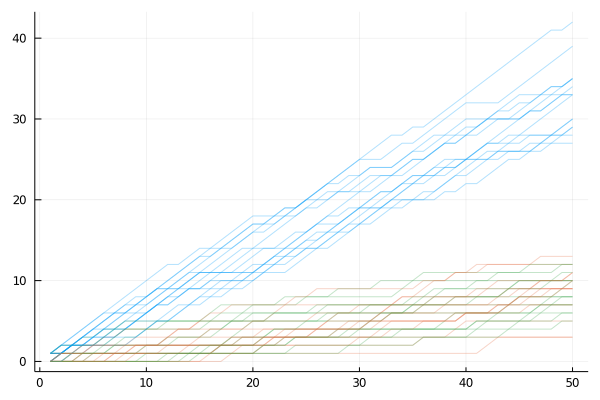

first win: 32.8+-4.143842247411039
ties: 8.533333333333333+-3.020564437950219
second win: 8.666666666666666+-2.225394561056747


In [78]:
simulate_game(-1, 0, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:11
Progress: 100%|█████████████████████████████████████████| Time: 0:04:12
Progress: 100%|█████████████████████████████████████████| Time: 0:04:10
Progress: 100%|█████████████████████████████████████████| Time: 0:04:11
Progress: 100%|█████████████████████████████████████████| Time: 0:04:11
Progress: 100%|█████████████████████████████████████████| Time: 0:04:14
Progress: 100%|█████████████████████████████████████████| Time: 0:05:54
Progress: 100%|█████████████████████████████████████████| Time: 0:06:02
Progress: 100%|█████████████████████████████████████████| Time: 0:06:11
Progress: 100%|█████████████████████████████████████████| Time: 0:06:22
Progress: 100%|█████████████████████████████████████████| Time: 0:05:41
Progress: 100%|█████████████████████████████████████████| Time: 0:05:17
Progress: 100%|█████████████████████████████████████████| Time: 0:04:59
Progress: 100%|█████████████████████████████████████████| Time: 

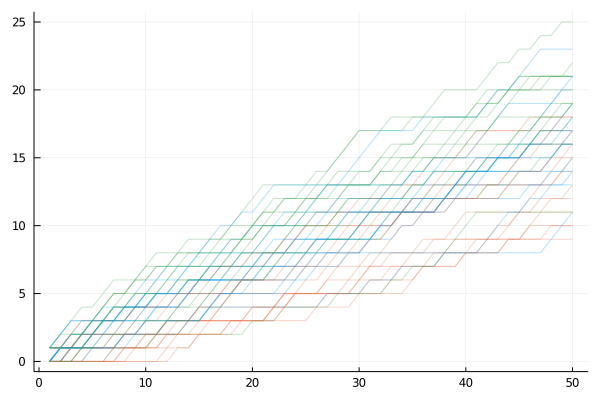

first win: 16.733333333333334+-3.1728010758108782
ties: 14.066666666666666+-3.058166272847333
second win: 19.2+-3.2115861679683624


In [79]:
simulate_game(0, 0, [1,10,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:05:00
Progress: 100%|█████████████████████████████████████████| Time: 0:04:55
Progress: 100%|█████████████████████████████████████████| Time: 0:04:59
Progress: 100%|█████████████████████████████████████████| Time: 0:04:57
Progress: 100%|█████████████████████████████████████████| Time: 0:04:57
Progress: 100%|█████████████████████████████████████████| Time: 0:05:00
Progress: 100%|█████████████████████████████████████████| Time: 0:04:56
Progress: 100%|█████████████████████████████████████████| Time: 0:04:57
Progress: 100%|█████████████████████████████████████████| Time: 0:05:00
Progress: 100%|█████████████████████████████████████████| Time: 0:05:26
Progress: 100%|█████████████████████████████████████████| Time: 0:05:57
Progress: 100%|█████████████████████████████████████████| Time: 0:06:01
Progress: 100%|█████████████████████████████████████████| Time: 0:06:05
Progress: 100%|█████████████████████████████████████████| Time: 

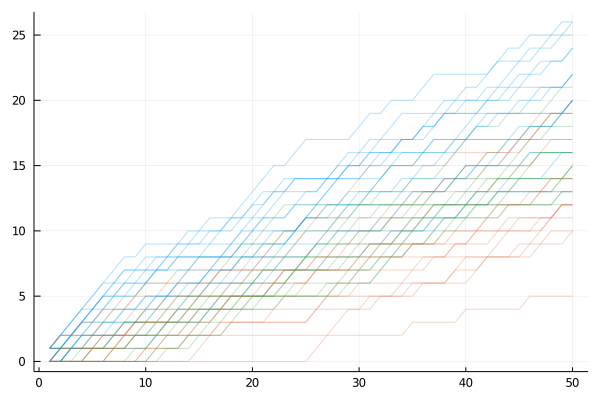

first win: 20.866666666666667+-3.961721607488099
ties: 13.333333333333334+-4.029651999626672
second win: 15.8+-2.6511453050656106


In [80]:
simulate_game(0, 0, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:10:06
Progress: 100%|█████████████████████████████████████████| Time: 0:09:38
Progress: 100%|█████████████████████████████████████████| Time: 0:09:26
Progress: 100%|█████████████████████████████████████████| Time: 0:09:26
Progress: 100%|█████████████████████████████████████████| Time: 0:09:26
Progress: 100%|█████████████████████████████████████████| Time: 0:09:25
Progress: 100%|█████████████████████████████████████████| Time: 0:09:31
Progress: 100%|█████████████████████████████████████████| Time: 0:10:49
Progress: 100%|█████████████████████████████████████████| Time: 0:10:10
Progress: 100%|█████████████████████████████████████████| Time: 0:10:14
Progress: 100%|█████████████████████████████████████████| Time: 0:09:33
Progress: 100%|█████████████████████████████████████████| Time: 0:09:39
Progress: 100%|█████████████████████████████████████████| Time: 0:09:47
Progress: 100%|█████████████████████████████████████████| Time: 

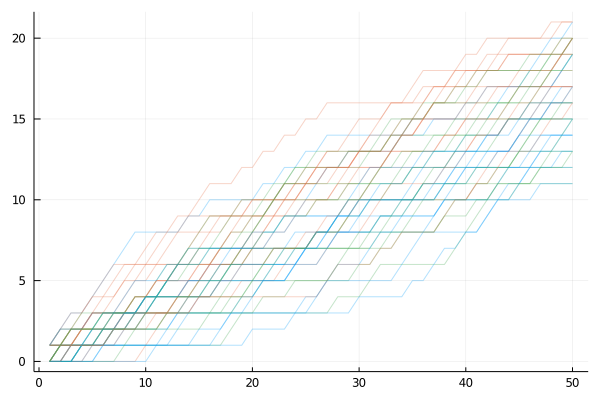

first win: 15.333333333333334+-2.819996622760558
ties: 18.533333333333335+-1.7674302033770737
second win: 16.133333333333333+-3.067494712224262


In [81]:
simulate_game(0, 1, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:09:50
Progress: 100%|█████████████████████████████████████████| Time: 0:10:07
Progress: 100%|█████████████████████████████████████████| Time: 0:09:28
Progress: 100%|█████████████████████████████████████████| Time: 0:09:35
Progress: 100%|█████████████████████████████████████████| Time: 0:09:26
Progress: 100%|█████████████████████████████████████████| Time: 0:09:25
Progress: 100%|█████████████████████████████████████████| Time: 0:09:26
Progress: 100%|█████████████████████████████████████████| Time: 0:09:26
Progress: 100%|█████████████████████████████████████████| Time: 0:09:27
Progress: 100%|█████████████████████████████████████████| Time: 0:09:26
Progress: 100%|█████████████████████████████████████████| Time: 0:09:27
Progress: 100%|█████████████████████████████████████████| Time: 0:09:26
Progress: 100%|█████████████████████████████████████████| Time: 0:09:27
Progress: 100%|█████████████████████████████████████████| Time: 

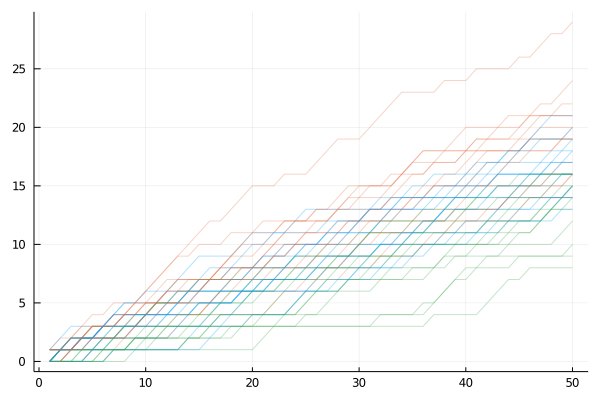

first win: 16.8+-2.3664319132398464
ties: 19.533333333333335+-3.7391111752597537
second win: 13.666666666666666+-2.716790823923031


In [82]:
simulate_game(1, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:14:44
Progress: 100%|█████████████████████████████████████████| Time: 0:14:45
Progress: 100%|█████████████████████████████████████████| Time: 0:14:45
Progress: 100%|█████████████████████████████████████████| Time: 0:14:44
Progress: 100%|█████████████████████████████████████████| Time: 0:16:03
Progress: 100%|█████████████████████████████████████████| Time: 0:15:43
Progress: 100%|█████████████████████████████████████████| Time: 0:15:28
Progress: 100%|█████████████████████████████████████████| Time: 0:16:21
Progress: 100%|█████████████████████████████████████████| Time: 0:17:15
Progress: 100%|█████████████████████████████████████████| Time: 0:14:59
Progress: 100%|█████████████████████████████████████████| Time: 0:14:39
Progress: 100%|█████████████████████████████████████████| Time: 0:14:38
Progress: 100%|█████████████████████████████████████████| Time: 0:14:39
Progress: 100%|█████████████████████████████████████████| Time: 

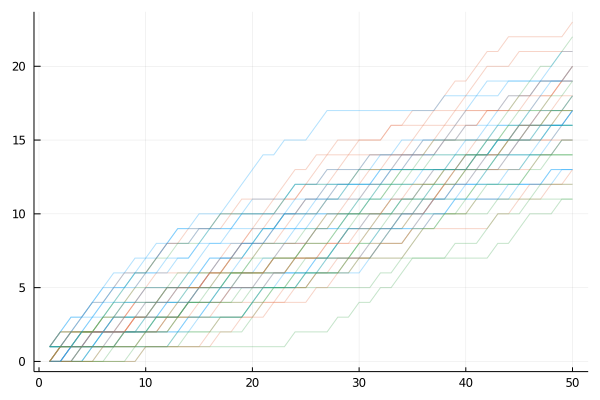

first win: 16.666666666666668+-2.4976179127511156
ties: 17.8+-3.0284366546831674
second win: 15.533333333333333+-3.020564437950219


In [83]:
simulate_game(1, 1, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:14:36
Progress: 100%|█████████████████████████████████████████| Time: 0:14:41
Progress: 100%|█████████████████████████████████████████| Time: 0:14:37
Progress: 100%|█████████████████████████████████████████| Time: 0:14:41
Progress: 100%|█████████████████████████████████████████| Time: 0:14:46
Progress: 100%|█████████████████████████████████████████| Time: 0:14:40
Progress: 100%|█████████████████████████████████████████| Time: 0:14:41
Progress: 100%|█████████████████████████████████████████| Time: 0:14:43
Progress: 100%|█████████████████████████████████████████| Time: 0:14:48
Progress: 100%|█████████████████████████████████████████| Time: 0:14:39
Progress: 100%|█████████████████████████████████████████| Time: 0:14:40
Progress: 100%|█████████████████████████████████████████| Time: 0:14:39
Progress: 100%|█████████████████████████████████████████| Time: 0:14:40
Progress: 100%|█████████████████████████████████████████| Time: 

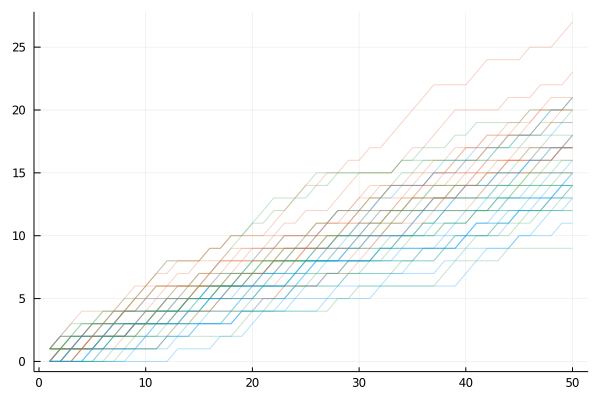

first win: 15.266666666666667+-2.737743248596934
ties: 19.066666666666666+-3.058166272847333
second win: 15.666666666666666+-3.2877840272018792


In [84]:
simulate_game(1, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:19:34
Progress: 100%|█████████████████████████████████████████| Time: 0:19:36
Progress: 100%|█████████████████████████████████████████| Time: 0:19:38
Progress: 100%|█████████████████████████████████████████| Time: 0:19:39
Progress: 100%|█████████████████████████████████████████| Time: 0:19:34
Progress: 100%|█████████████████████████████████████████| Time: 0:19:39
Progress: 100%|█████████████████████████████████████████| Time: 0:19:34
Progress: 100%|█████████████████████████████████████████| Time: 0:19:32
Progress: 100%|█████████████████████████████████████████| Time: 0:20:12
Progress: 100%|█████████████████████████████████████████| Time: 0:19:48
Progress: 100%|█████████████████████████████████████████| Time: 0:19:30
Progress: 100%|█████████████████████████████████████████| Time: 0:19:32
Progress: 100%|█████████████████████████████████████████| Time: 0:19:31
Progress: 100%|█████████████████████████████████████████| Time: 

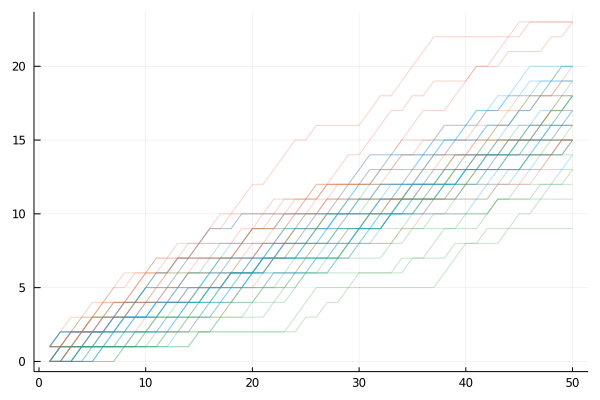

first win: 17.0+-1.927248223318863
ties: 17.8+-3.1441555759399513
second win: 15.2+-3.1892677171144745


Progress: 100%|█████████████████████████████████████████| Time: 0:19:36


In [85]:
simulate_game(2, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:19:35
Progress: 100%|█████████████████████████████████████████| Time: 0:19:34
Progress: 100%|█████████████████████████████████████████| Time: 0:19:32
Progress: 100%|█████████████████████████████████████████| Time: 0:19:32
Progress: 100%|█████████████████████████████████████████| Time: 0:19:35
Progress: 100%|█████████████████████████████████████████| Time: 0:19:39
Progress: 100%|█████████████████████████████████████████| Time: 0:19:36
Progress: 100%|█████████████████████████████████████████| Time: 0:19:37
Progress: 100%|█████████████████████████████████████████| Time: 0:19:39
Progress: 100%|█████████████████████████████████████████| Time: 0:19:36
Progress: 100%|█████████████████████████████████████████| Time: 0:19:38
Progress: 100%|█████████████████████████████████████████| Time: 0:19:37
Progress: 100%|█████████████████████████████████████████| Time: 0:19:36
Progress: 100%|█████████████████████████████████████████| Time: 

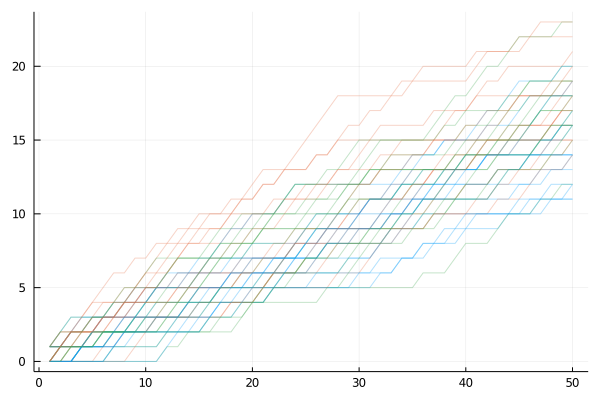

first win: 14.733333333333333+-2.840187787218772
ties: 17.933333333333334+-2.737743248596934
second win: 17.333333333333332+-2.4976179127511156


In [ ]:
simulate_game(1, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:23:40
Progress: 100%|█████████████████████████████████████████| Time: 0:26:42
Progress: 100%|█████████████████████████████████████████| Time: 0:23:52
Progress: 100%|█████████████████████████████████████████| Time: 0:23:38
Progress: 100%|█████████████████████████████████████████| Time: 0:23:32
Progress: 100%|█████████████████████████████████████████| Time: 0:23:43
Progress: 100%|█████████████████████████████████████████| Time: 0:23:37
Progress: 100%|█████████████████████████████████████████| Time: 0:23:31
Progress: 100%|█████████████████████████████████████████| Time: 0:23:27
Progress: 100%|█████████████████████████████████████████| Time: 0:23:32
Progress: 100%|█████████████████████████████████████████| Time: 0:23:30
Progress: 100%|█████████████████████████████████████████| Time: 0:23:34
Progress: 100%|█████████████████████████████████████████| Time: 0:23:34
Progress: 100%|█████████████████████████████████████████| Time: 

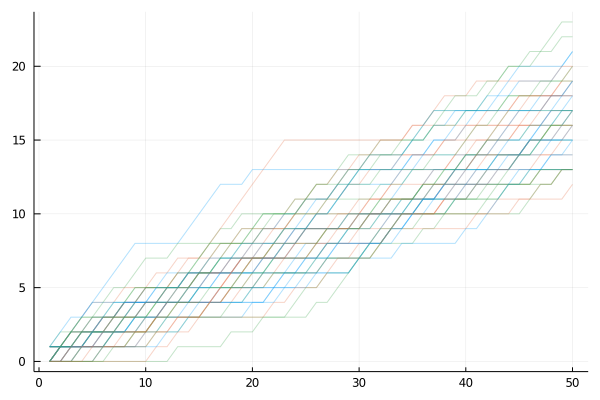

first win: 17.0+-2.390457218668787
ties: 16.533333333333335+-2.587515815456612
second win: 16.466666666666665+-3.335237551331167


In [ ]:
simulate_game(2, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:25:029m
Progress: 100%|█████████████████████████████████████████| Time: 1:07:23
Progress: 100%|█████████████████████████████████████████| Time: 0:23:33
Progress: 100%|█████████████████████████████████████████| Time: 0:23:20
Progress: 100%|█████████████████████████████████████████| Time: 0:23:19
Progress: 100%|█████████████████████████████████████████| Time: 0:23:17
Progress: 100%|█████████████████████████████████████████| Time: 0:23:24
Progress: 100%|█████████████████████████████████████████| Time: 0:23:18
Progress: 100%|█████████████████████████████████████████| Time: 0:23:17
Progress: 100%|█████████████████████████████████████████| Time: 0:23:21
Progress: 100%|█████████████████████████████████████████| Time: 0:23:20
Progress: 100%|█████████████████████████████████████████| Time: 0:23:17
Progress: 100%|█████████████████████████████████████████| Time: 0:23:15
Progress: 100%|█████████████████████████████████████████| Time

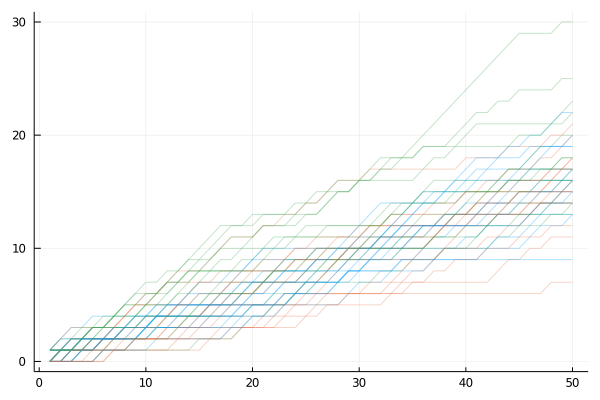

first win: 16.066666666666666+-3.2175116087406668
ties: 15.333333333333334+-3.559026084010437
second win: 18.6+-4.656792274271453


In [ ]:
simulate_game(2, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:13:59
Progress: 100%|█████████████████████████████████████████| Time: 0:13:59
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:13:58
Progress: 100%|█████████████████████████████████████████| Time: 0:13:58
Progress: 100%|█████████████████████████████████████████| Time: 0:14:02
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:14:01
Progress: 100%|█████████████████████████████████████████| Time: 0:14:01
Progress: 100%|█████████████████████████████████████████| Time: 0:14:02
Progress: 100%|█████████████████████████████████████████| Time: 0:13:58
Progress: 100%|█████████████████████████████████████████| Time: 0:14:24
Progress: 100%|█████████████████████████████████████████| Time: 

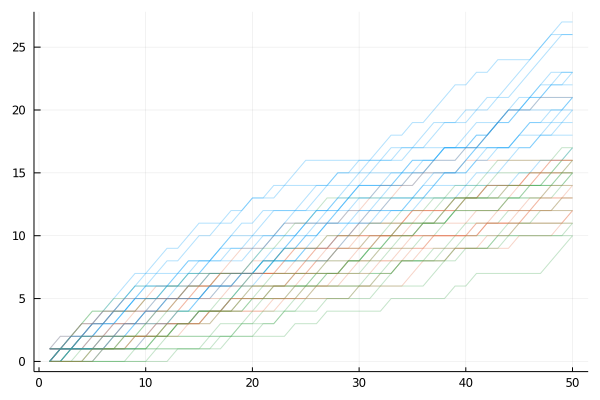

first win: 21.8+-2.932575659723036
ties: 14.4+-2.5014281634983755
second win: 13.8+-2.4553149347021512


In [ ]:
simulate_game(2, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:13:56
Progress: 100%|█████████████████████████████████████████| Time: 0:14:09
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:13:58
Progress: 100%|█████████████████████████████████████████| Time: 0:14:02
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:13:59
Progress: 100%|█████████████████████████████████████████| Time: 0:14:05
Progress: 100%|█████████████████████████████████████████| Time: 0:14:01
Progress: 100%|█████████████████████████████████████████| Time: 0:14:02
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 

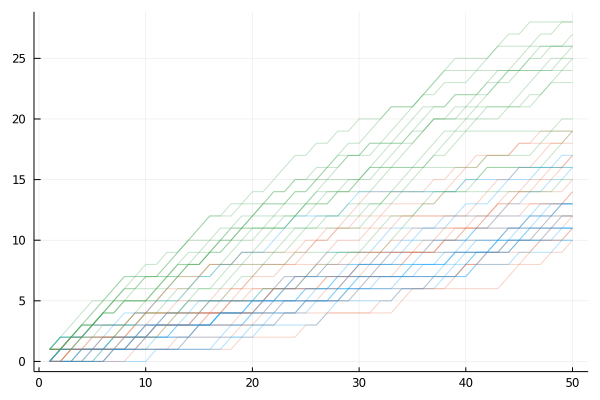

first win: 12.6+-2.1974010622941433
ties: 14.266666666666667+-3.0581662728473336
second win: 23.133333333333333+-4.273952113286562


In [ ]:
simulate_game(0, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:18:41
Progress: 100%|█████████████████████████████████████████| Time: 0:18:34
Progress: 100%|█████████████████████████████████████████| Time: 0:18:46
Progress: 100%|█████████████████████████████████████████| Time: 0:18:34
Progress: 100%|█████████████████████████████████████████| Time: 0:18:37
Progress: 100%|█████████████████████████████████████████| Time: 0:18:35
Progress: 100%|█████████████████████████████████████████| Time: 0:18:34
Progress: 100%|█████████████████████████████████████████| Time: 0:18:36
Progress: 100%|█████████████████████████████████████████| Time: 0:18:37
Progress: 100%|█████████████████████████████████████████| Time: 0:18:43
Progress: 100%|█████████████████████████████████████████| Time: 0:18:36
Progress: 100%|█████████████████████████████████████████| Time: 0:18:37
Progress: 100%|█████████████████████████████████████████| Time: 0:18:40
Progress: 100%|█████████████████████████████████████████| Time: 

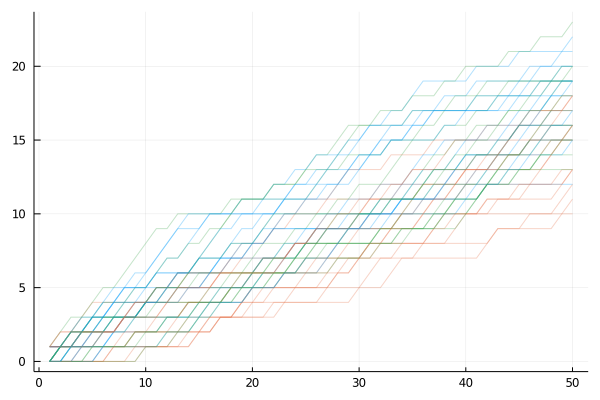

first win: 17.933333333333334+-2.631313269796951
ties: 14.733333333333333+-2.6040261866871424
second win: 17.333333333333332+-2.6903708365381966


In [ ]:
simulate_game(3, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:38
Progress: 100%|█████████████████████████████████████████| Time: 0:18:18
Progress: 100%|█████████████████████████████████████████| Time: 0:18:37
Progress: 100%|█████████████████████████████████████████| Time: 0:20:15
Progress: 100%|█████████████████████████████████████████| Time: 0:18:53
Progress: 100%|█████████████████████████████████████████| Time: 0:18:35
Progress: 100%|█████████████████████████████████████████| Time: 0:18:31
Progress: 100%|█████████████████████████████████████████| Time: 0:18:32
Progress: 100%|█████████████████████████████████████████| Time: 0:18:31
Progress: 100%|█████████████████████████████████████████| Time: 0:18:34
Progress: 100%|█████████████████████████████████████████| Time: 0:18:32
Progress: 100%|█████████████████████████████████████████| Time: 0:18:32
Progress: 100%|█████████████████████████████████████████| Time: 0:18:33
Progress: 100%|█████████████████████████████████████████| Time: 

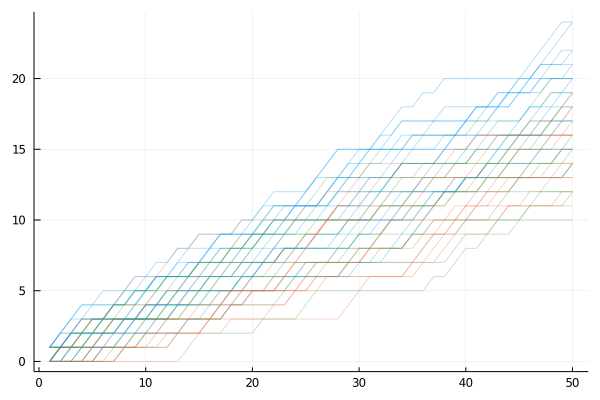

first win: 19.6+-2.9712912056160747
ties: 15.066666666666666+-2.3441924185608345
second win: 15.333333333333334+-2.9680841985233184


In [ ]:
simulate_game(0, 3, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:38:3939m
Progress: 100%|█████████████████████████████████████████| Time: 0:48:12
Progress: 100%|█████████████████████████████████████████| Time: 0:31:08
Progress: 100%|█████████████████████████████████████████| Time: 0:35:35
Progress: 100%|█████████████████████████████████████████| Time: 0:29:21
Progress: 100%|█████████████████████████████████████████| Time: 0:28:44
Progress: 100%|█████████████████████████████████████████| Time: 0:28:43
Progress: 100%|█████████████████████████████████████████| Time: 0:32:30
Progress: 100%|█████████████████████████████████████████| Time: 0:31:59
Progress: 100%|█████████████████████████████████████████| Time: 0:29:56███████████████████                 |  ETA: 0:11:57
Progress: 100%|█████████████████████████████████████████| Time: 0:32:19
Progress: 100%|█████████████████████████████████████████| Time: 0:31:47
Progress: 100%|█████████████████████████████████████████| Time: 0:32:39
Progress: 

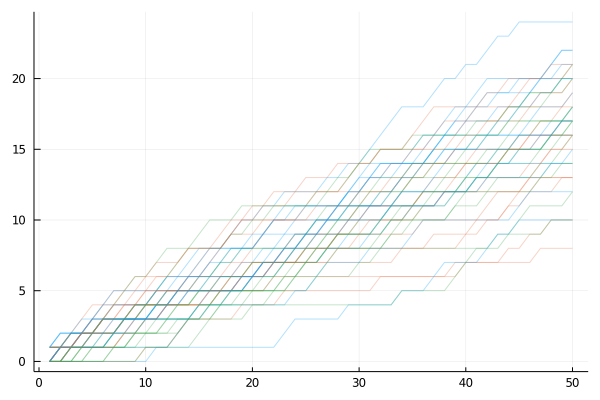

first win: 17.8+-3.931557306862366
ties: 15.733333333333333+-3.8446004188930187
second win: 16.466666666666665+-2.996823715361379


In [ ]:
simulate_game(2, 3, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:27:27
Progress: 100%|█████████████████████████████████████████| Time: 0:27:24
Progress: 100%|█████████████████████████████████████████| Time: 0:27:23
Progress: 100%|█████████████████████████████████████████| Time: 0:27:30
Progress: 100%|█████████████████████████████████████████| Time: 0:27:33
Progress: 100%|█████████████████████████████████████████| Time: 0:27:34
Progress: 100%|█████████████████████████████████████████| Time: 0:27:25
Progress: 100%|█████████████████████████████████████████| Time: 0:27:35
Progress: 100%|█████████████████████████████████████████| Time: 0:27:23
Progress: 100%|█████████████████████████████████████████| Time: 0:27:26
Progress: 100%|█████████████████████████████████████████| Time: 0:28:18
Progress: 100%|█████████████████████████████████████████| Time: 0:28:49
Progress: 100%|█████████████████████████████████████████| Time: 0:27:28
Progress: 100%|█████████████████████████████████████████| Time: 

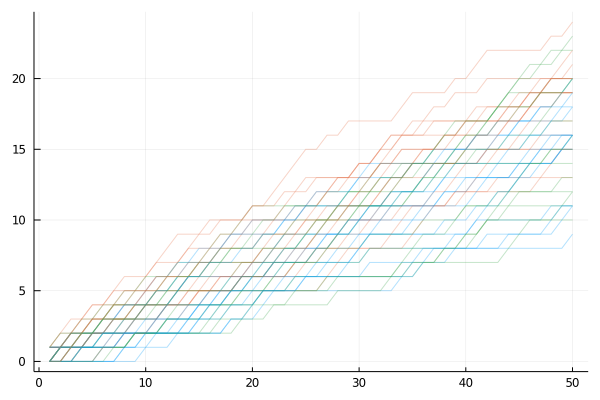

first win: 15.133333333333333+-3.24844285041017
ties: 18.6+-2.9228166454393167
second win: 16.266666666666666+-4.216746658379227


In [ ]:
simulate_game(3, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

## Summery
* The history overwrite the prior pretty fast when looking on history
* when adding theory of mind from 0 to 1 the player succeed to exploit the inbalanced prior
* when going towards higher depth's we see that the effect above not working anymore (but the result is going to Nash-EQ). need more expirments
* we need to see how larger then 1 difference in theory of mind parameter affect the results

TODO:
* increase the num of rounds
* adding more example with different levels of theory of mind (2,0) , (0, 2)